# Part III : What is the relative importance of each component of the OLMAR algorithm ?


#### Initialization

In [1]:
%matplotlib inline
import pandas as pd
from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

# remove warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib
# increase the size of graphs
matplotlib.rcParams['savefig.dpi'] *= 1.5
import matplotlib.pyplot as plt
import seaborn

/Users/Code/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/Code/anaconda/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [13]:
# load data using tools module
data = tools.dataset('tse') #DO NOT USE NYSE (it has the survivorship bias)

params = { 
    "window" : 5,       
    "epsilon": 10,
}

# Instanciate OLMAR algorithm
olmar = algos.OLMAR(window=params["window"], eps=params["epsilon"])
result_classic = olmar.run(data)

## Experiments

## 1. Filtering

### Online random reversion 

In order to measure the importance of moving average in prediction, 
We compare the OLMAR with the Online random moving reversion

In [4]:
from universal.algo import Algo
import numpy as np

In [18]:
from online_classes import OLRANDOM
olrandom = OLRANDOM(window=params["window"], eps=params["epsilon"])
result_random = olrandom.run(data)

In [6]:
from online_classes import OLGAUSS
olgauss = OLGAUSS(mu = 1, sigma = 0.01)
result_gauss = olgauss.run(data)

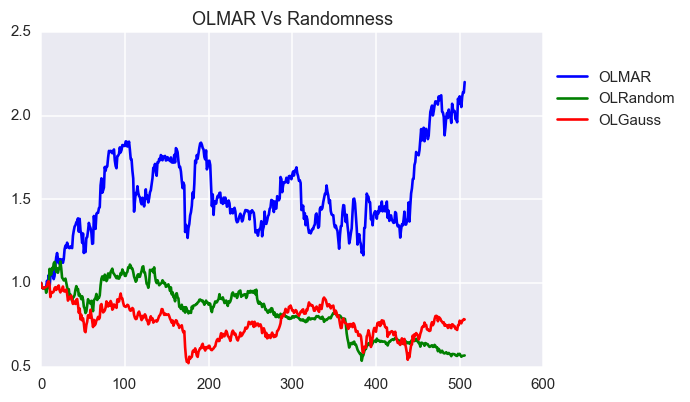

In [7]:
plt.figure()

ax = plt.gca()
#ax.set_yscale('log')

plt.plot(result_classic.equity, label ='OLMAR', color='blue' )
plt.plot(result_random.equity, label = 'OLRandom' , color='green')
plt.plot(result_gauss.equity, label = 'OLGauss' , color='red')

plt.title("OLMAR Vs Randomness")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.show()

### Similar filters (multi period mean reversion)

Now instead of using the moving average, we will plug different filter :

- exponential weighted moving average
- median
- max
- min 

In [14]:
from online_classes import OLMAX, OLMIN, OLMEDIAN, OLEWM

In [15]:
olmax = OLMAX(window=params["window"], eps=params["epsilon"])
result_max = olmax.run(data)

In [16]:
olmin = OLMAX(window=params["window"], eps=params["epsilon"])
result_min = olmin.run(data)

olmedian = OLMEDIAN(window=params["window"], eps=params["epsilon"])
result_median = olmedian.run(data)

olewm = OLEWM(window=params["window"], eps=params["epsilon"])
result_ewm = olewm.run(data)

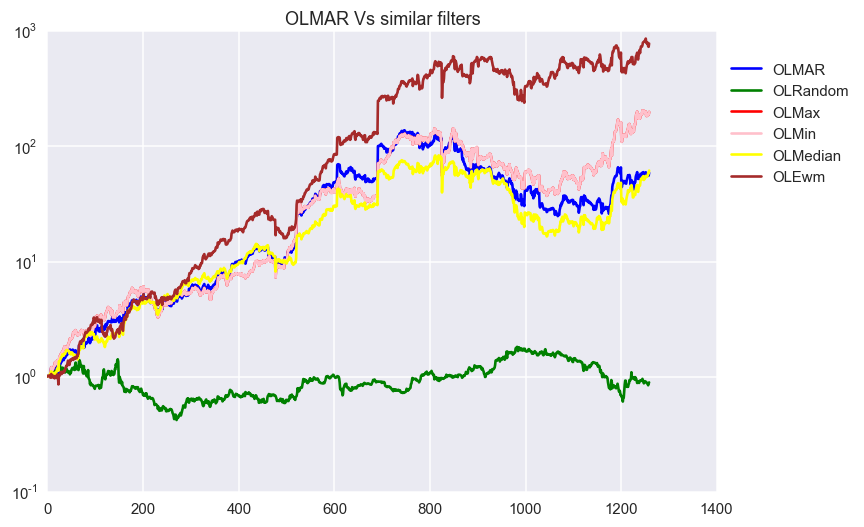

In [20]:
plt.figure()

ax = plt.gca()
ax.set_yscale('log')

plt.plot(result_classic.equity, label ='OLMAR', color='blue' )
plt.plot(result_random.equity, label = 'OLRandom' , color='green')
plt.plot(result_max.equity, label = 'OLMax' , color='red')
plt.plot(result_min.equity, label = 'OLMin' , color='pink')
plt.plot(result_median.equity, label = 'OLMedian' , color='yellow')
plt.plot(result_ewm.equity, label = 'OLEwm' , color='brown')

plt.title("OLMAR Vs similar filters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.show()

### Different filters : KCA

In [70]:
from universal.algo import Algo
import numpy as np
import sys
sys.path.append('/Users/Code/Desktop/tmp netanya/charles_and_ran_1606/code')
from filters import KCA

class OLKCA(Algo):

    PRICE_TYPE = 'raw'
    REPLACE_MISSING = True

    def __init__(self, window=5, eps=10, seed=1):
        """
        :param window: Lookback window.
        :param eps: Constraint on return for new weights on last price (average of prices).
            x * w >= eps for new weights w.
        """

        super(OLKCA, self).__init__(min_history=window)

        # input check
        if window < 2:
            raise ValueError('window parameter must be >=3')
        if eps < 1:
            raise ValueError('epsilon parameter must be >=1')

        self.window = window
        self.eps = eps
        self.kca = KCA(seed)

    def init_weights(self, m):
        return np.ones(m) / m

    def step(self, x, last_b, history):
        # calculate return prediction
        x_pred = self.predict(x, history.iloc[-self.window:])
        b = self.update(last_b, x_pred, self.eps)
        return b


    def predict(self, x, history):
        """ Predict returns on next day. 
            THIS IS OUR MAIN MODIFICATION
        """
        x_pred = np.zeros(history.shape[1])
        for i in range(history.shape[1]):
            x_pred[i] = self.kca.get_all_filter(np.asanyarray(history[[i]]))[-1]
        return x_pred / x

    def update(self, b, x, eps):
        """ Update portfolio weights to satisfy constraint b * x >= eps
        and minimize distance to previous weights. """
        x_mean = np.mean(x)
        lam = max(0., (eps - np.dot(b, x)) / np.linalg.norm(x - x_mean)**2)

        # limit lambda to avoid numerical problems
        lam = min(100000, lam)

        # update portfolio
        b = b + lam * (x - x_mean)

        # project it onto simplex
        return tools.simplex_proj(b)

In [71]:
olkca = OLKCA(window = 15, seed=1)
result_kca = olkca.run(data)

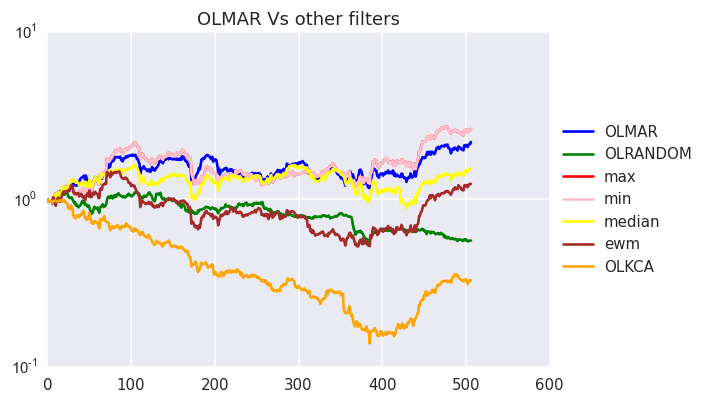

In [72]:
plt.figure()

ax = plt.gca()
ax.set_yscale('log')

plt.plot(result_classic.equity, label ='OLMAR', color='blue' )
plt.plot(result_random.equity, label = 'OLRANDOM' , color='green')
plt.plot(result_max.equity, label = 'max' , color='red')
plt.plot(result_min.equity, label = 'min' , color='pink')
plt.plot(result_median.equity, label = 'median' , color='yellow')
plt.plot(result_ewm.equity, label = 'ewm' , color='brown')
plt.plot(result_kca .equity, label = 'OLKCA' , color='orange')

plt.title("OLMAR Vs other filters")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Allocation

### passive agressive illustration

In [12]:
# load data using tools module
data = tools.dataset('tse') #DO NOT USE NYSE (it has the survivorship bias)

params = { 
    "window" : 5,       
    "epsilon": 10,
}

# Instanciate OLMAR algorithm
olmar = algos.OLMAR(window=params["window"], eps=params["epsilon"])
result_classic = olmar.run(data)

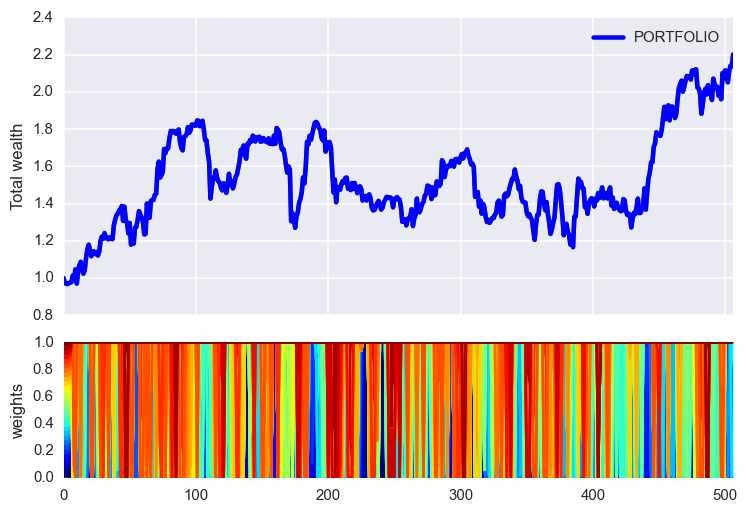

In [10]:
# Plotting performances against the UCRP baseline with log-scale on y axis
result_classic.plot(weights=True, assets=False, ucrp=False, logy=False)

### A simpler allocation

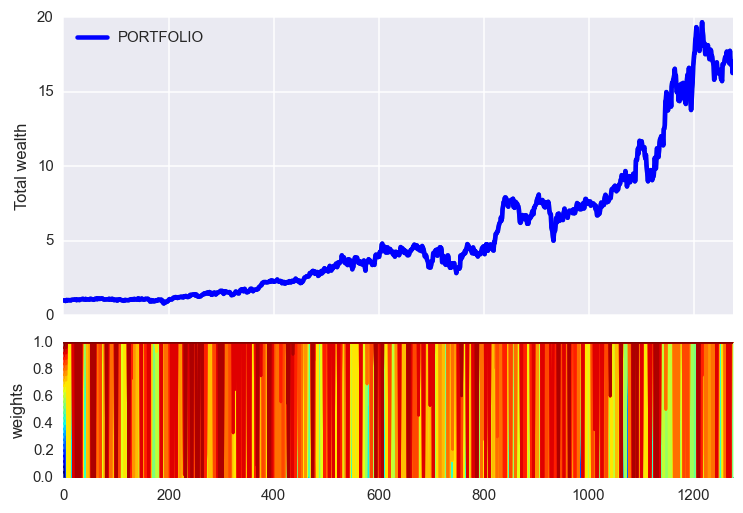

In [12]:
result_classic.plot(weights=True, assets=False, ucrp=False, logy=False)

In [3]:
from online_classes import OLMAR_max_k

In [8]:
# Instanciate OLMAR algorithm
olmar_1 = OLMAR_max_k(window=params["window"], eps=params["epsilon"], k = 1)
result_max_1 = olmar_1.run(data)

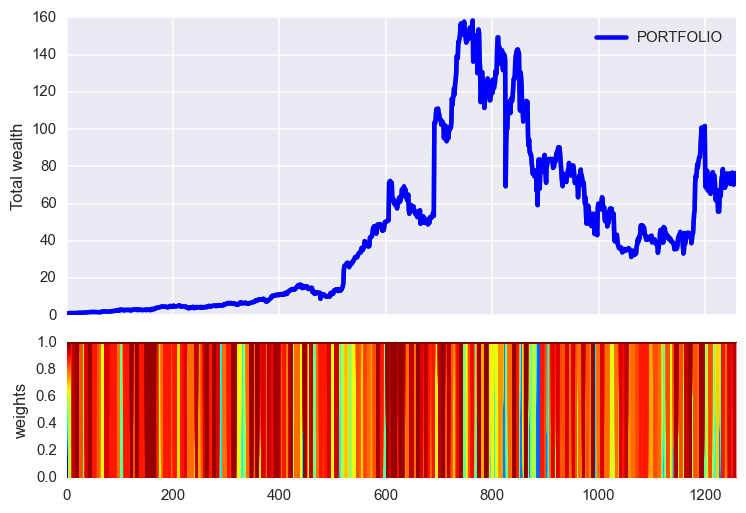

In [9]:
# Plotting performances against the UCRP baseline with log-scale on y axis
result_max_1.plot(weights=True, assets=False, ucrp=False, logy=False)

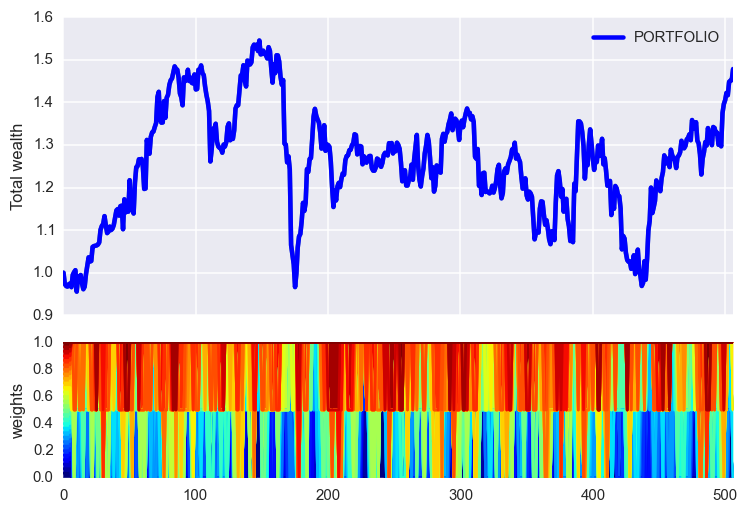

In [8]:
# Instanciate OLMAR algorithm
olmar_2 = OLMAR_max_k(window=params["window"], eps=params["epsilon"], k = 2)
result_max_2 = olmar_2.run(data)
result_max_2.plot(weights=True, assets=False, ucrp=False, logy=False)

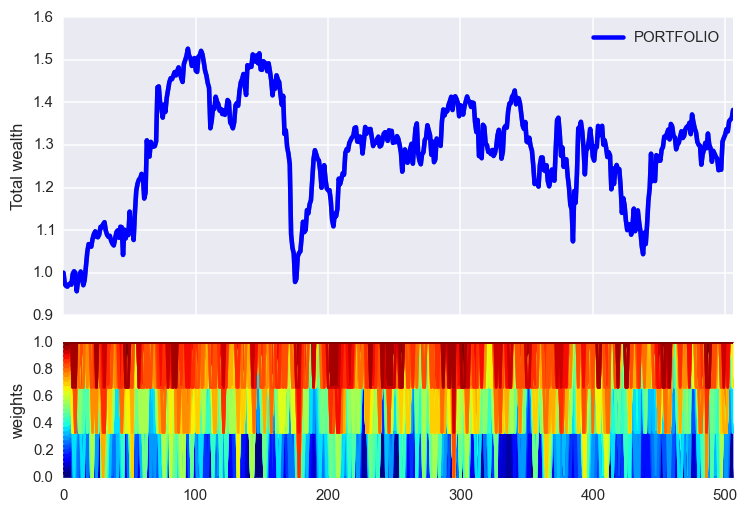

In [9]:
# Instanciate OLMAR algorithm
olmar_3 = OLMAR_max_k(window=params["window"], eps=params["epsilon"], k = 3)
result_max_3 = olmar_3.run(data)
result_max_3.plot(weights=True, assets=False, ucrp=False, logy=False)